In [1]:
import pandas as pd
from pathlib import Path 
import torch
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
import fastai.learner as learner
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
path_data = Path('data')
path = path_data/'训练验证数据集'
path_train = path/'训练数据集'
path_train_data = [path_train/f'信号类型{i}训练集.txt' for i in range(1,13)]
names = ['ts','f_a','f_b','f_c','f_d','cat']

In [3]:
df_train = pd.concat([pd.read_csv(o,sep='\s+',header=None,names=names) for o in path_train_data])

In [4]:
path_val = path/'验证数据集'
path_val_data = [path_val/f'验证集{i}.txt' for i in range(1,4)]
df_val = pd.concat([pd.read_csv(o,sep='\s+',header=None,names=names) for o in path_val_data])

In [5]:
cont_names = ['f_a','f_b','f_c','f_d']
y_names = 'cat'
procs = [Normalize]
batch_size = bs = 512
cbs=[ProgressCallback(),ShowGraphCallback(),TrackerCallback(),MCDropoutCallback()]

In [6]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))
to = TabularPandas(df_train, procs=procs,
                   cont_names = cont_names,
                   y_names=y_names,
                   splits=splits)
dls = to.dataloaders(bs=bs)

In [7]:
dls.show_batch()

,f_a,f_b,f_c,f_d,cat
0,9582.690430,1.88,-16.340000,42.200001,11.0
1,9596.040039,10.01,-4.690001,48.599998,5.0
2,9563.059570,9.48,-31.910000,59.869999,7.0
3,9614.309570,9.15,-15.260000,58.380001,1.0
4,9637.089844,9.18,-19.809999,48.540001,4.0
5,9580.799805,8.16,-11.680000,46.189999,6.0
6,9625.389648,9.06,-42.250000,48.639999,5.0
7,9651.009766,2.02,-28.100000,40.689999,11.0
8,9581.790039,1.53,-19.950001,42.860001,11.0
9,9599.690430,9.47,-30.010000,50.020000,5.0


In [22]:
learn = tabular_learner(dls,layers=[256,128])

In [16]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=4, out_features=256, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=256, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

SuggestedLRs(valley=0.004365158267319202)

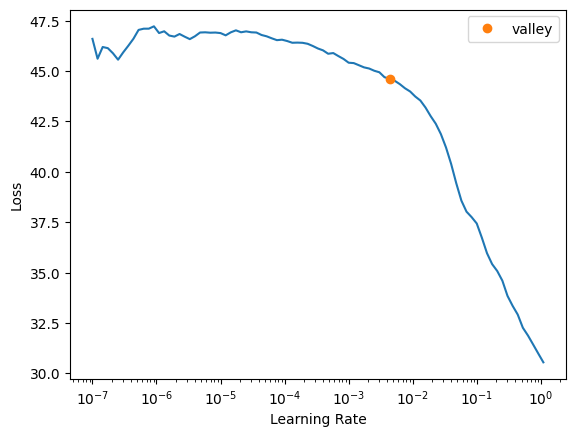

In [17]:
learn.lr_find()

In [23]:
learn.fit(3,lr=0.01,cbs=cbs)

epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time
0,0.225596,0.260007,00:33
1,0.201756,0.172564,00:31


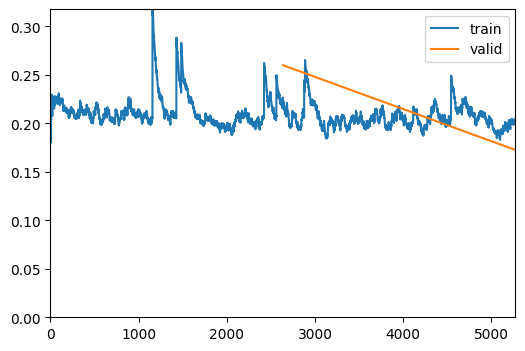

In [24]:
learn.fit(2,lr=0.001,cbs=cbs)

In [25]:
learn.show_results(max_n=20)

,f_a,f_b,f_c,f_d,cat,cat_pred
0,0.146566,0.317080,0.671235,-0.349300,5.0,4.979694
1,0.084576,0.122741,0.650719,1.369003,8.0,7.924553
2,0.116961,0.349026,-0.412024,-0.509351,5.0,4.940135
3,0.122712,0.085470,0.832288,-0.401797,5.0,4.961520
4,0.108364,0.173322,0.509157,-0.808965,6.0,5.972769
5,0.106625,-0.231329,0.962566,-0.641232,6.0,6.208173
6,0.182287,-1.863245,-5.037419,-1.267350,11.0,10.876972
7,0.165211,0.026902,-0.138132,-0.669401,4.0,4.114176
8,0.165109,-0.023679,0.045489,-0.565688,4.0,4.129479
9,0.135671,-0.031666,0.617893,-1.193087,2.0,2.092445


In [26]:
dl = learn.dls.test_dl(df_train)
pred = learn.get_preds(dl=dl)
(abs(pred[0]).round().clamp(1,12) == pred[1]).float().mean()

tensor(0.8833)

In [27]:
dl = learn.dls.test_dl(df_val)
pred = learn.get_preds(dl=dl)
(abs(pred[0]).round().clamp(1,12) == pred[1]).float().mean()

tensor(0.1937)